In [2]:
# https://worldpopulationreview.com/state-rankings/guns-per-capita		
# https://worldpopulationreview.com/state-rankings/gun-deaths-by-state		
# https://worldpopulationreview.com/state-rankings/most-republican-states


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

            State  gunsRegistered      Pop  Registered Rate  \
11        Wyoming          132806   581075         0.228552   
31  New Hampshire           64135  1372200         0.046739   
17     New Mexico           97580  2105000         0.046356   
3        Virginia          307822  8603980         0.035777   
36   Rhode Island           37152  1061510         0.034999   

    Death Rate per 100K partisanVotingIndexRebublican  
11                 13.4                           red  
31                  6.6                          gray  
17                 13.9                          blue  
3                  11.5                          blue  
36                  3.6                          blue  
0.34524294800194794


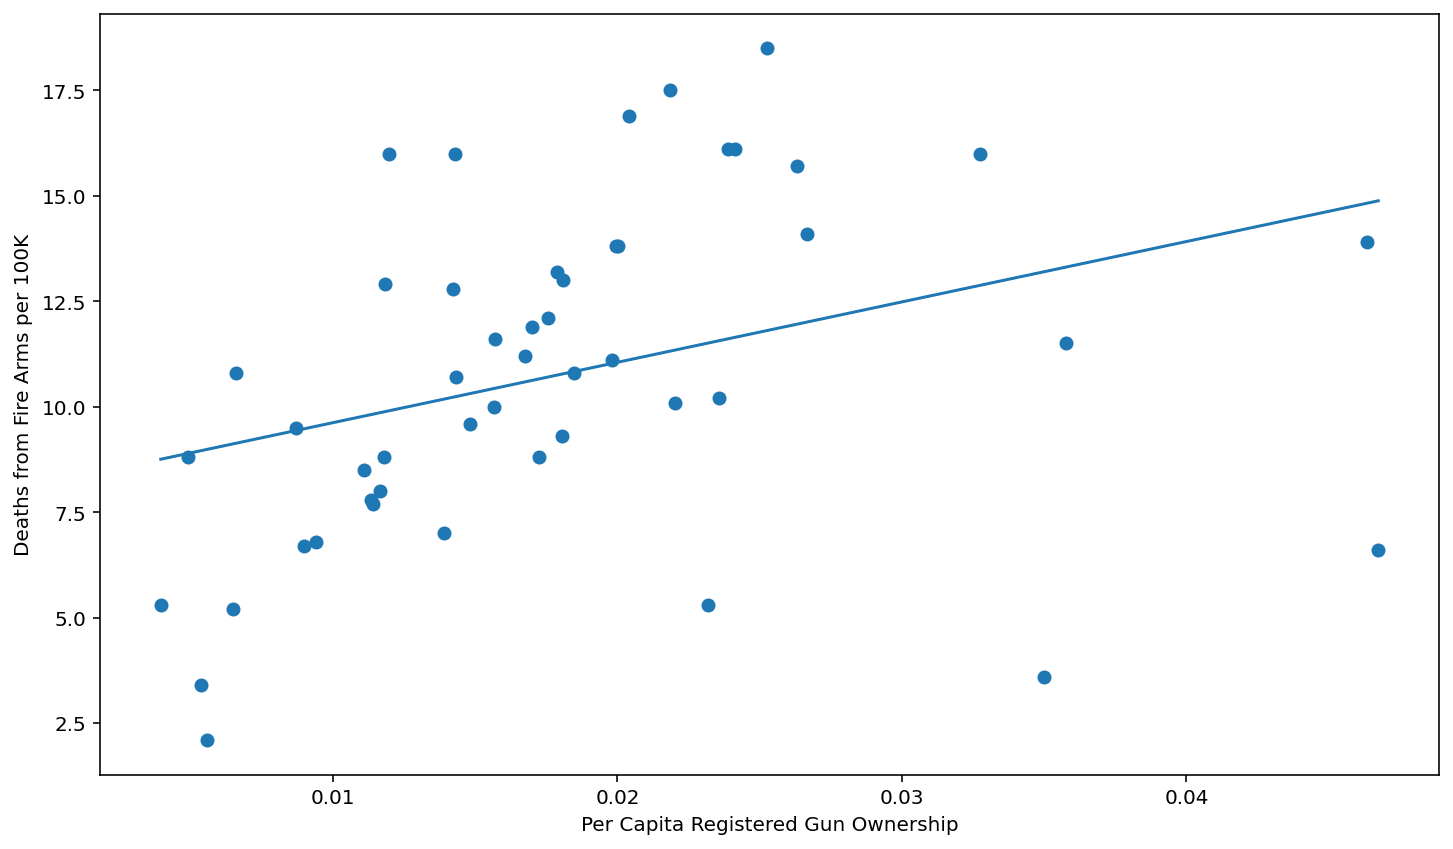

In [3]:

def do_party_color(a):
    if a == "":
        a = 'gray'
    elif int(a) > 0:
        a = 'red'
    else: a = 'blue'
    return a


deaths_df = pd.read_csv("deaths.csv", header=0, names=['State', 'Death Rate per 100K'], sep='\t', skiprows=1, index_col=False)
guns_df = pd.read_csv("registered.csv", sep='\t', skiprows=1)
party_df = pd.read_csv("politicalaffiliation.csv", sep=',', skiprows=0, converters={'partisanVotingIndexRebublican':do_party_color})

guns_df['Registered Rate'] = guns_df['gunsRegistered']/guns_df['Pop']

gun_deaths_df = guns_df.merge(deaths_df, on='State')
gun_deaths_df = gun_deaths_df.merge(party_df, on='State')
gun_deaths_df.sort_values(by=['Registered Rate'], inplace=True, ascending=False )
print(gun_deaths_df.head())

gun_deaths_df = gun_deaths_df[gun_deaths_df['State'] != 'Wyoming']
guns = gun_deaths_df['Registered Rate'].to_numpy()

deaths = gun_deaths_df['Death Rate per 100K'].to_numpy() #.reshape(-1, 1)

party_s = gun_deaths_df['partisanVotingIndexRebublican']

deaths_s = pd.Series(deaths)
guns_s = pd.Series(guns)
deaths.reshape(-1,1)

print(guns_s.corr(deaths_s))

lr = LinearRegression()
#lr.fit(gun_deaths_df['Death Rate per 100K'].to_numpy().reshape(-1, 1), gun_deaths_df['Registered Rate'].to_numpy())
lr.fit(guns.reshape(-1, 1), deaths)

#print('Coefficient of determination:', lr.score(lr.predict(guns.reshape(-1,1)), deaths))
plt.ylabel("Deaths from Fire Arms per 100K")
plt.xlabel("Per Capita Registered Gun Ownership")
plt.scatter(guns, deaths)
plt.plot(guns, lr.predict(guns.reshape(-1,1)))
#plt.scatter(gun_deaths_df['Death Rate per 100K'],gun_deaths_df['Registered Rate']) #, 'ro')
#plt.plot(gun_deaths_df['Death Rate per 100K'], w*gun_deaths_df['Death Rate per 100K'])
#plt.plot(gun_deaths_df['Death Rate per 100K'], lr.predict(gun_deaths_df['Death Rate per 100K'].to_numpy().reshape(-1, 1)))

plt.show()


In [4]:

from bokeh.models.tools import HoverTool
from bokeh.io import curdoc
from bokeh.io import save, output_file
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Grid, LinearAxis, Plot, Scatter
from bokeh.io import output_notebook
from bokeh.models.tools import BoxZoomTool, ResetTool
output_notebook()

states_s = gun_deaths_df['State']

lr = LinearRegression()
lr.fit(guns.reshape(-1, 1), deaths)
pred = lr.predict(guns.reshape(-1,1))
print(type(pred))

party_name = party_s.copy()


party = pd.DataFrame(party_s)

party['party_name'] = party['partisanVotingIndexRebublican'].apply(lambda x: 'Democratic' if x =='blue' else ('Borderline' if x=='gray' else 'Republican'))

source = ColumnDataSource(dict(x=guns_s, 
                       y=deaths_s, 
                       states=states_s, 
                       dot_color=party_s, 
                       party_name=party['party_name'],
                       pred=pred))   #, markers=markers))
#print(source.x)

hover = HoverTool( 
    tooltips = [("Per capita registered guns: ","@x{1.111}"),
                ("Deaths per 100,000", "@y"),
                ("State", "@states"),
                ])
# title="Gun Deaths vs. Per Capita Registration")
#plot = Plot(plot_width=700, plot_height=300, min_border=0, toolbar_location=None,tools=[hover])

p = figure(plot_width=1000, 
           plot_height=600, 
           min_border=0, 
           tools=[hover, BoxZoomTool(), ResetTool()],
           title="Gun Deaths vs. Per Capita Registration")



p.scatter(x='x' ,y='y', source=source, size=10, 
          fill_color='dot_color', 
          marker='circle',                                
          legend_group='party_name') 

#, legend_label="Red is Republican \nBlue is Democratic \nGray is borderline.")

p.line(source=source, x='x', y='pred', legend_label="Least Squares Fit = 0.345")

p.yaxis.axis_label = 'Gun Deaths per 100,000'
p.xaxis.axis_label = 'Per Capita Registered Guns'
p.legend.border_line_width = 3
p.legend.border_line_color = "black"

print('Coefficient of correlation: ', guns_s.corr(deaths_s))
show(p)

#save(p,filename=r'gun_deaths_bokeh.html' )
#output_file('gun_deaths_bokeh.html',mode='inline')



Loading BokehJS ...

<class 'numpy.ndarray'>
Coefficient of correlation:  0.34524294800194794
